# Спринт 15 «Временные ряды»

# Проект «Прогнозирование заказов такси»

## Навигация

1. [Описание проекта](#Описание-проекта)
1. [Описание данных](#Описание-данных)
1. [Подготовка данных](#Подготовка-данных)
1. [Анализ данных](#Анализ-данных)
1. [Feature enginering](#Feature-enginering)
1. [Обучение](#Обучение)
   - [CatBoost](#CatBoost)
   - [Линейная модель](#Линейная-модель)
1. [Тестирование](#Тестирование)
1. [Общие выводы](#Общие-выводы)

## Описание проекта

[к навигации](#Навигация)

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

## Описание данных

[к навигации](#Навигация)

Количество заказов находится в столбце `num_orders`.

In [1]:
import os

import catboost

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

In [2]:
RANDOM_STATE = 42

## Подготовка данных

[к навигации](#Навигация)

In [3]:
data = pd.read_csv(
    os.path.join('..', 'datasets', 'taxi.csv'),
    index_col='datetime',
    parse_dates=['datetime'],
)
data = data.resample('1H').sum()

In [4]:
if data.index.is_monotonic_increasing:
    print('Индекс монотонно возрастает')
else:
    print('Индекс либо не монотонен, либо не возрастает')

Индекс монотонно возрастает


## Анализ данных

[к навигации](#Навигация)

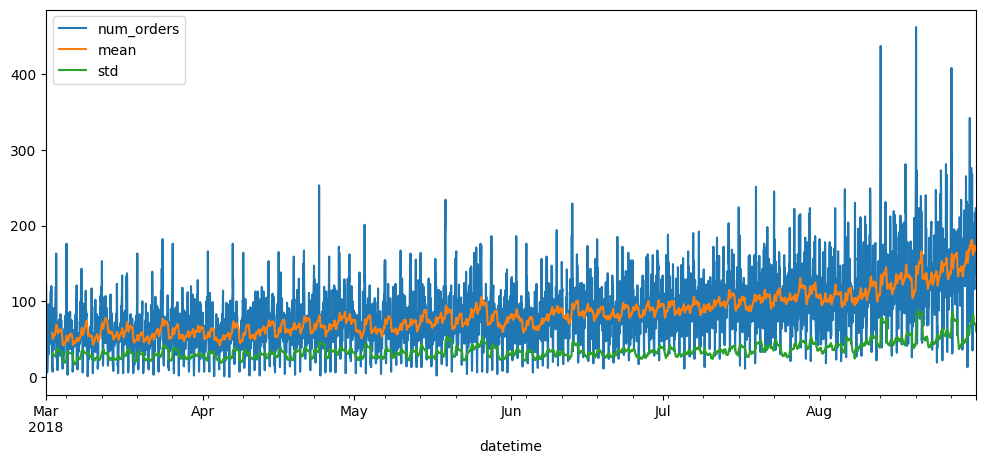

In [5]:
data_analysis = data.copy()

data_analysis['mean'] = data_analysis['num_orders'].rolling(30).mean()
data_analysis['std'] = data_analysis['num_orders'].rolling(30).std()

fig, ax = plt.subplots(figsize=(12, 5))
data_analysis.plot(ax=ax)
plt.show()

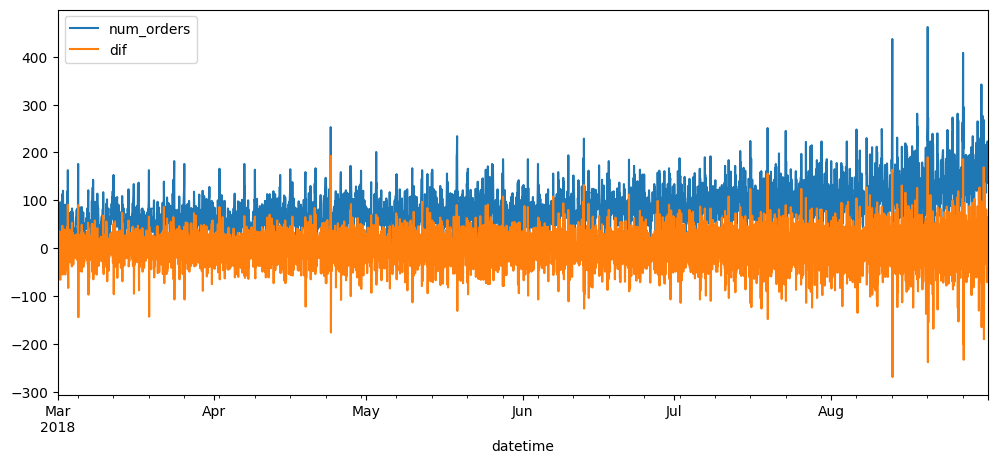

In [6]:
data_analysis = data.copy()

data_analysis[f'dif'] = data_analysis['num_orders'] - data_analysis['num_orders'].shift(1)
    
fig, ax = plt.subplots(figsize=(12, 5))
data_analysis.plot(ax=ax)
plt.show()

In [7]:
decomposed = seasonal_decompose(data)

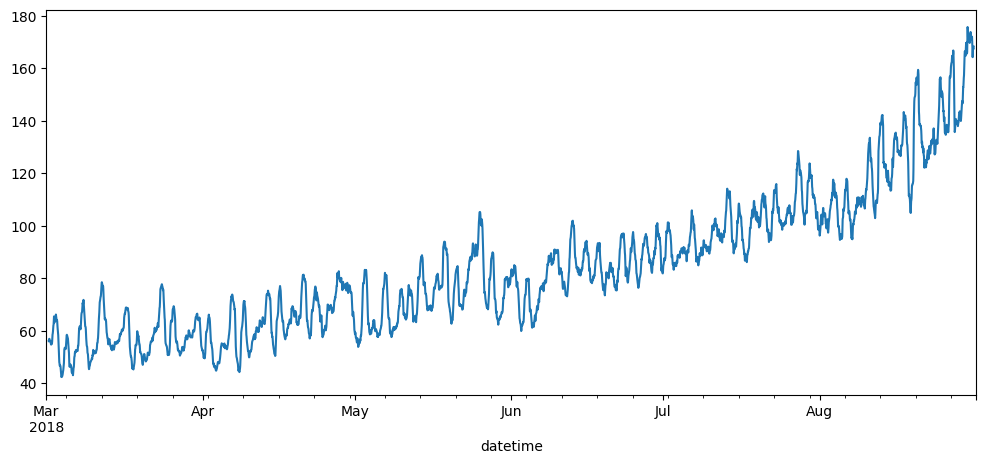

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))
decomposed.trend.plot(ax=ax)
plt.show()

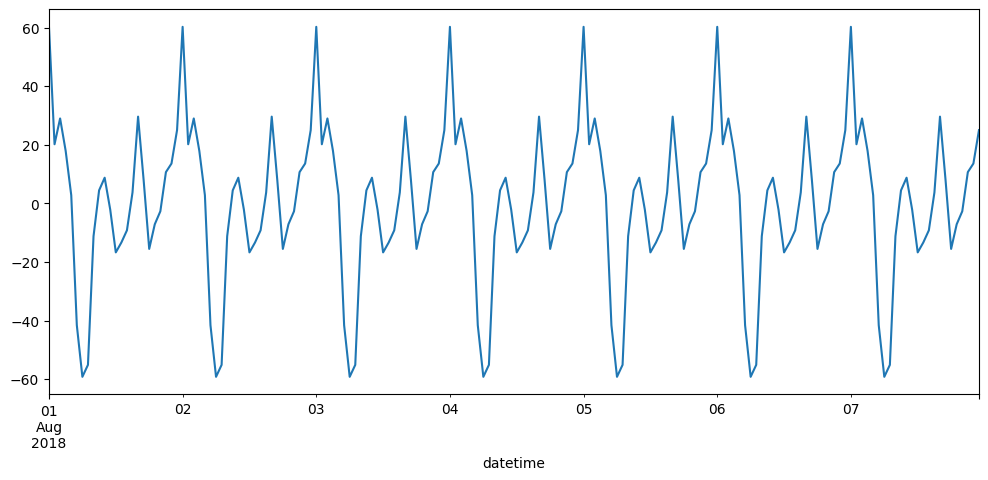

In [9]:
# сезонность за неделю
fig, ax = plt.subplots(figsize=(12, 5))
decomposed.seasonal['2018-08-01': '2018-08-07'].plot(ax=ax)
plt.show()

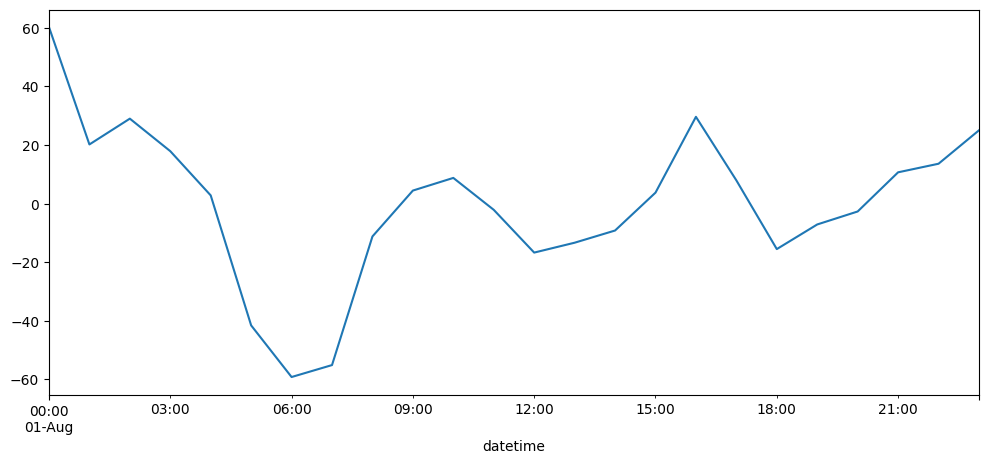

In [10]:
# сезонность за сутки
fig, ax = plt.subplots(figsize=(12, 5))
decomposed.seasonal['2018-08-01': '2018-08-01'].plot(ax=ax)
plt.show()

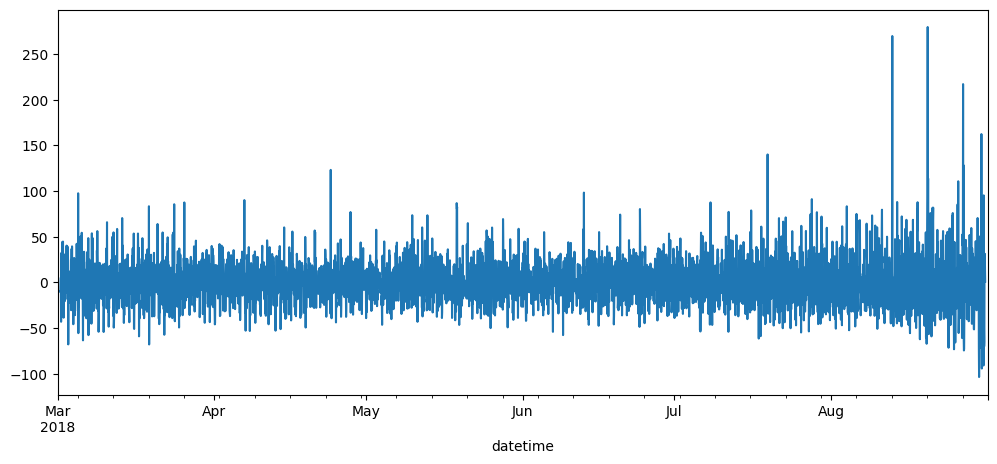

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
decomposed.resid.plot(ax=ax)
plt.show()

__Выводы:__ 
- На графике тренда "наблюдается квадратичный тренд"
- На грфике сезонности наблюдается цикличность кажде сутки. Можно отметить пмаксимум заказов в полночь и минимум в 6 утра.
- График остатков выглядит как стационарный ряд.

## Feature enginering

[к навигации](#Навигация)

In [12]:
def make_features(df, rolling_mean_size):
    df = df.copy()

    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    for i in rolling_mean_size:
        df[f'rolling_mean_{i}'] = df['num_orders'].shift().rolling(i).mean()

    return df

In [13]:
data = make_features(data, [7, 14, 30])

## Обучение

[к навигации](#Навигация)

In [14]:
X = data.drop(columns='num_orders')
y = data['num_orders']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=RANDOM_STATE)

### CatBoost

[к навигации](#Навигация)

In [16]:
%%time
gs_catboost = GridSearchCV(
    estimator=catboost.CatBoostRegressor(cat_features=['dayofweek'], verbose=0, random_state=RANDOM_STATE),
    param_grid={
        'max_depth': [4, 8, 16],
        'learning_rate': [0.3, 0.4, 0.5],
        'iterations': [30, 50, 60],
    },
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=TimeSeriesSplit(),
)
gs_catboost.fit(X_train, y_train)

CPU times: total: 2.98 s
Wall time: 27min 42s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001CD0118AFE0>,
             n_jobs=-1,
             param_grid={'iterations': [30, 50, 60],
                         'learning_rate': [0.3, 0.4, 0.5],
                         'max_depth': [4, 8, 16]},
             scoring='neg_mean_squared_error')

In [17]:
print('Лучшие гиперпараметры:')
for param, value in gs_catboost.best_params_.items():
    print(f'{param}: {value}')

Лучшие гиперпараметры:
iterations: 50
learning_rate: 0.4
max_depth: 8


In [18]:
print(f'Метрика RMSE на CatBoost: {(-gs_catboost.best_score_) ** 0.5:.2f}')

Метрика RMSE на CatBoost: 25.89


### Линейная модель

[к навигации](#Навигация)

In [19]:
gs_linear = GridSearchCV(
    estimator=Ridge(random_state=RANDOM_STATE),
    param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
    scoring='neg_mean_squared_error',
    cv=TimeSeriesSplit(),
)
gs_linear.fit(X_train.fillna(0), y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(random_state=42),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9]},
             scoring='neg_mean_squared_error')

In [20]:
print('Лучшие гиперпараметры:')
for param, value in gs_linear.best_params_.items():
    print(f'{param}: {value}')

Лучшие гиперпараметры:
alpha: 0.9


In [21]:
print(f'Метрика RMSE на линейной модели: {(-gs_linear.best_score_) ** 0.5:.2f}')

Метрика RMSE на линейной модели: 36.31


Выбираем модель на CatBoost'e

In [22]:
model = gs_catboost.best_estimator_

## Тестирование

[к навигации](#Навигация)

In [23]:
y_pred = model.predict(X_test)

In [24]:
mean_squared_error(y_test, y_pred) ** .5

45.66292811283171

## Общие выводы

[к навигации](#Навигация)

- Анализ временного ряда показал наличие тренда с квадратичной составляющей, наличие сезонности с дневным циклом, а ткже статичность ряда остатков.
- В качестве признаков мы нагенерили день недели, час суток и скользящие средние по 7, 14 и 30 дням.
- В качестве моделей мы рассматривали CatBoost и Ridge.
- Для настройки гиперпараметров использовали кросс-валидацию с TimeSeriesSplit.
- По итогам была выбрана модель на основе CatBoost, на тестовом наборе показавшая RMSE=45.66